Plan:
* modele parametryczne (Logistic, KNN, SVM)
* modele nieparametryczne (tree, forest, adaboost)

Dla każdego modelu zrobić GridSearch

Potem między modelami zrobić model voting

In [72]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

# modele parametryczne
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# modele nieparametryczne
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import dtreeviz

In [73]:
penguins = pd.read_csv('penguins.csv')
penguins.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
3,NaN,NaN,NaN,NaN,0
4,36.7,19.3,193.0,3450.0,0


## Wstępna ocena danych

In [74]:
penguins.isna().value_counts()

CulmenLength  CulmenDepth  FlipperLength  BodyMass  Species
False         False        False          False     False      342
True          True         True           True      False        2
Name: count, dtype: int64

In [75]:
penguins.dropna(inplace=True)

In [76]:
features = penguins.columns[:-1].to_list()
target = 'Species'

In [77]:
X, y = penguins[features], penguins[target]

In [78]:
X.describe()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [79]:
pd.Series(y).value_counts(normalize=True)

Species
0    0.441520
1    0.359649
2    0.198830
Name: proportion, dtype: float64

In [80]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CulmenLength   342 non-null    float64
 1   CulmenDepth    342 non-null    float64
 2   FlipperLength  342 non-null    float64
 3   BodyMass       342 non-null    float64
 4   Species        342 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.0 KB


Unique values: 164


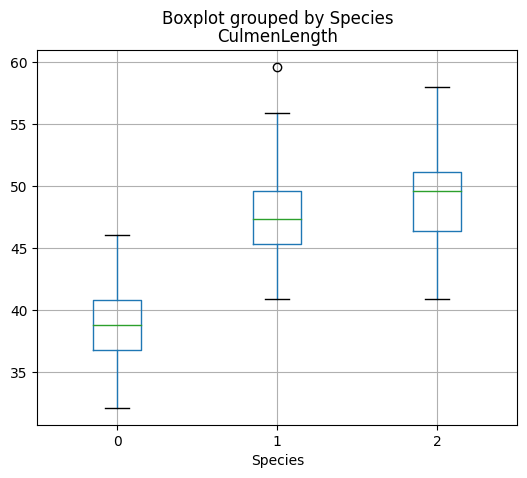

Unique values: 80


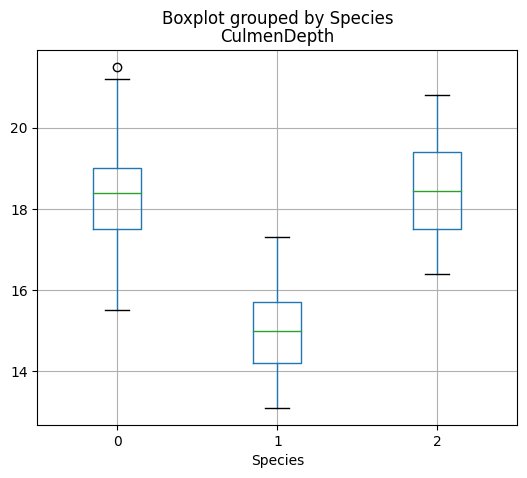

Unique values: 55


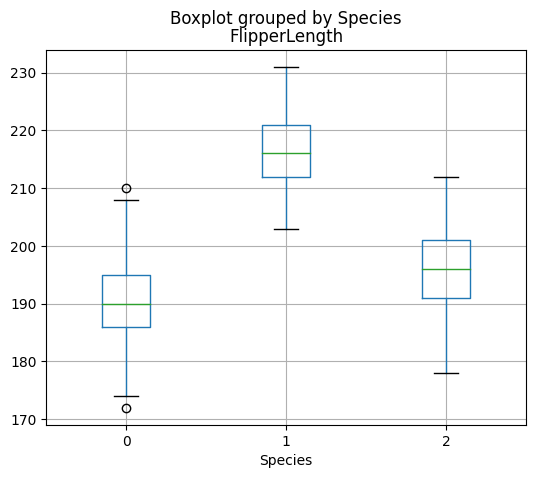

Unique values: 94


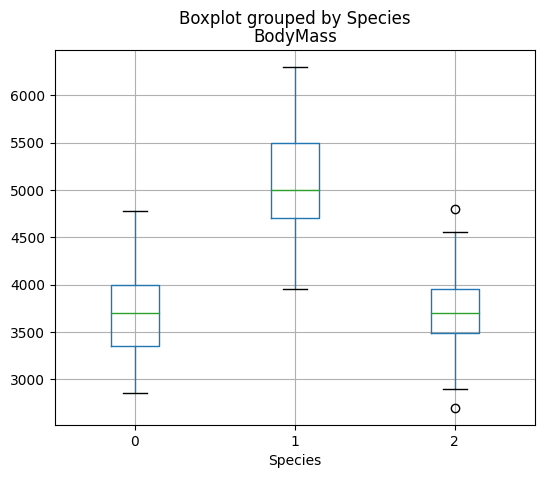

In [81]:
for col in features:
    print(f'Unique values: {penguins[col].nunique()}')
    penguins.boxplot(column=col, by='Species', figsize=(6,5))
    plt.title(col)
    plt.show()

Czy występuje korelacja między długością ogona a masą?

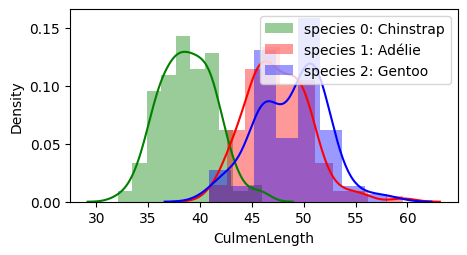

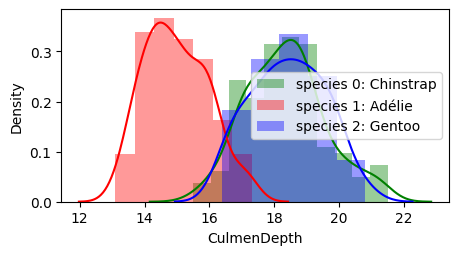

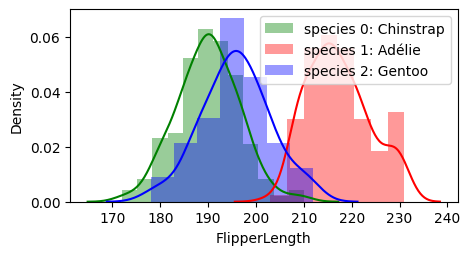

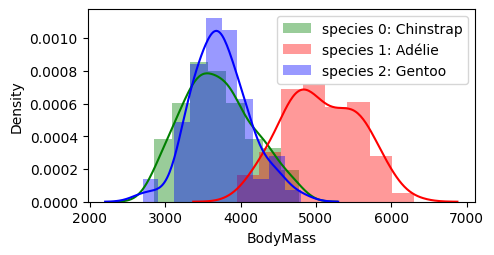

In [82]:
for col in features:
    plt.figure(figsize=(5,2.5))
    sns.distplot(penguins.loc[penguins['Species']==0, col], color='green', label='species 0: Chinstrap')
    sns.distplot(penguins.loc[penguins['Species']==1, col], color='red', label='species 1: Adélie')
    sns.distplot(penguins.loc[penguins['Species']==2, col], color='blue', label='species 2: Gentoo')
    plt.legend()
    plt.show()

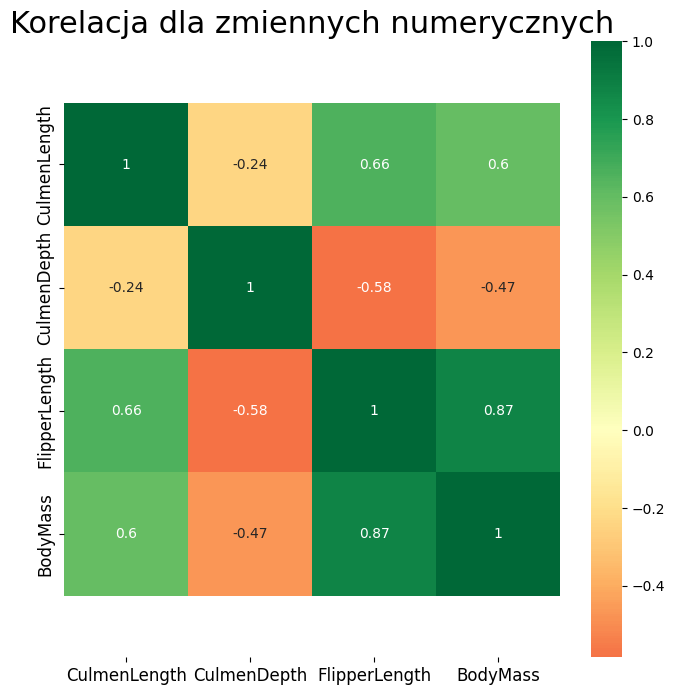

In [83]:
plt.figure(figsize=(8,8))
ax = sns.heatmap(X.corr(),
                xticklabels=X.corr().columns,
                yticklabels=X.corr().columns,
                cmap='RdYlGn',
                center=0,
                annot=True)
plt.title('Korelacja dla zmiennych numerycznych', fontsize=22)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Jest pewna korelacja między długością ogona i masą, jednak niewystarczająco duża, by usunąć którąś z tych danych.

Współczynnik korelacji punktowo-dwuseryjnej (Point-biserial correlation coefficient).

In [84]:
corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col],y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

CulmenLength     0.779857
FlipperLength    0.357472
BodyMass         0.209717
CulmenDepth     -0.183090
dtype: float64

Długość dzioba zdaje się mieć największe znaczenie, jednak może warto wziąć pod uwagę pozostałe zmienne również.

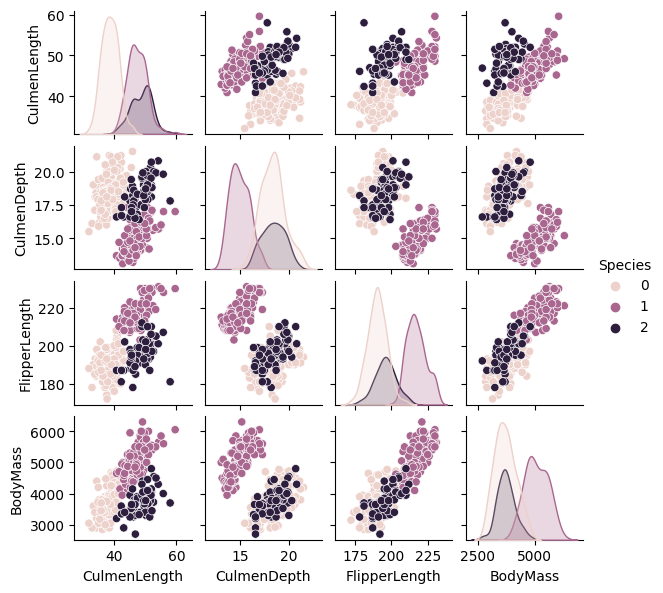

In [85]:
sns.pairplot(penguins,hue='Species', height=1.5)

Wygląda na to, że możnaby podejmować decyzjena podstawie długości i grubości dzioba, pod tym względem gatunki są separowalne z pewnym marginesem.

In [86]:
pd.get_dummies(y, dtype=int).values

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Przekształcanie danych

### Podział danych na treningowe i testowe

In [87]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
print ('Treningowe obserwacje: %d\nTestowe obserwacje: %d' % (X_train.shape[0], X_test.shape[0]))

Treningowe obserwacje: 239
Testowe obserwacje: 103


#### Przeskalowanie zmiennych

In [88]:
scaler = StandardScaler()
X_train_standardized, X_test_standardized = \
    scaler.fit_transform(X_train), scaler.transform(X_test)

In [89]:
def model_evaluation(trained_model, model_name, X_testing, y_testing):
    prediction = trained_model.predict(X_testing)
    prediction_probability = trained_model.predict_proba(X_testing)
    
    roc_score = roc_auc_score(y_testing, prediction_probability, multi_class='ovr', average='micro')
    f1_score_ = f1_score(y_testing, prediction, labels=['0','1','2'], average='weighted')

    print(f"ROC_AUC_score: {roc_score}")
    print(f"F1_score: {f1_score_}")

    plt.figure(figsize=(4,4))
    cm = confusion_matrix(y_testing, prediction)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title(f'Confusion Matrix {model_name}\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    print(classification_report(y_testing, prediction))
    
    return model_name, roc_score, f1_score_

## Modele

### Parametry domyślne i zmienne

#### modele parametryczne

Logistic Regression

In [90]:
model_lr = LogisticRegression(multi_class='ovr', penalty='elasticnet', solver='saga', random_state=0)
params_lr = {'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1],
             'C': [0.01, 0.1, 1, 10, 100]}

K Nearest Neighbors

In [91]:
model_knn = KNeighborsClassifier(weights='uniform')
params_knn = {'n_neighbors': [int(0.01*X_train_standardized.shape[0])*j for j in [1, 2, 5, 10]],
              'weights': ['uniform', 'distance']}

Support Vector Machines

In [92]:
model_svm = SVC(kernel='rbf', probability=True, random_state=0)
params_svm = {'C': [0.01, 0.1, 1, 10, 100],
              'decision_function_shape': ['ovo', 'ovr']}

#### modele nie-parametryczne

Decision Tree Classifier

In [93]:
model_tree = DecisionTreeClassifier(random_state=0)
params_tree = {'min_samples_leaf': [int(0.01*X_train.shape[0])*j for j in [1, 2, 5, 10]],
               'max_depth': [1, 2, 5, None]}

Random Forest Classifier

In [94]:
model_forest = RandomForestClassifier(random_state=0)
params_forest = {'n_estimators': [10,100, 1000],
                'min_samples_leaf': [int(0.01*X_train.shape[0])*j for j in [1, 2, 5, 10]],
               'max_depth': [1, 2, 5, None]}

AdaBoost Classifier

In [95]:
model_adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=None), random_state=0)
params_adaboost = {'n_estimators': [10, 50, 100],
                   'learning_rate': [0.01, 0.1, 1, 10]}

### Określenie optymalnych parametrów

#### modele parametryczne

In [96]:
lr_gridsearch = GridSearchCV(model_lr,
                             params_lr,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
lr_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', lr_gridsearch.best_params_)
model_lr_best = lr_gridsearch.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best hyperparameter: {'C': 10, 'l1_ratio': 0.1}


In [97]:
knn_gridsearch = GridSearchCV(model_knn,
                             params_knn,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
knn_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', knn_gridsearch.best_params_)
model_knn_best = knn_gridsearch.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best hyperparameter: {'n_neighbors': 4, 'weights': 'distance'}


In [98]:
svm_gridsearch = GridSearchCV(model_svm,
                             params_svm,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
svm_gridsearch.fit(X_train_standardized, y_train)
print('\nBest hyperparameter:', svm_gridsearch.best_params_)
model_svm_best = svm_gridsearch.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameter: {'C': 100, 'decision_function_shape': 'ovo'}


#### modele nie-parametryczne

In [99]:
tree_gridsearch = GridSearchCV(model_tree,
                             params_tree,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
tree_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_gridsearch.best_params_)
model_tree_best = tree_gridsearch.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 2}


In [100]:
forest_gridsearch = GridSearchCV(model_forest,
                             params_forest,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
forest_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', forest_gridsearch.best_params_)
model_forest_best = forest_gridsearch.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits



Best hyperparameter: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}


In [101]:
adaboost_gridsearch = GridSearchCV(model_adaboost,
                             params_adaboost,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
adaboost_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', adaboost_gridsearch.best_params_)
model_adaboost_best = adaboost_gridsearch.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best hyperparameter: {'learning_rate': 0.01, 'n_estimators': 10}


## Ocena modeli

In [102]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])

In [103]:
models_parametric = [model_lr_best, model_knn_best, model_svm_best]
models_parametric_names = ['Logistic_Regression', 'KNN', 'SVM']

models_nonparametric = [model_tree_best, model_forest_best, model_adaboost_best]
models_nonparametric_names = ['Tree', 'Random_forest', 'AdaBoost']

ROC_AUC_score: 0.9728768027146762
F1_score: 0.9512019014196295


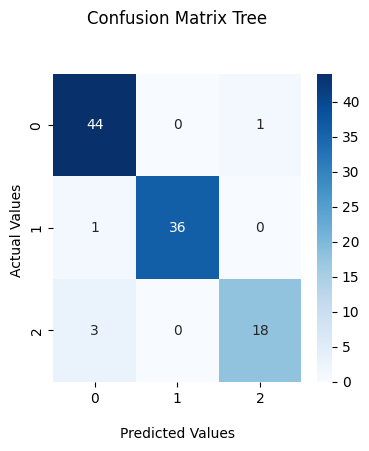

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        45
           1       1.00      0.97      0.99        37
           2       0.95      0.86      0.90        21

    accuracy                           0.95       103
   macro avg       0.95      0.94      0.94       103
weighted avg       0.95      0.95      0.95       103

ROC_AUC_score: 0.9967480441134885
F1_score: 0.9706786228216491


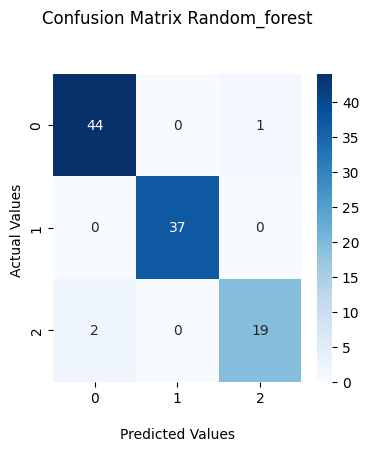

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103

ROC_AUC_score: 0.970873786407767
F1_score: 0.9606162937948501


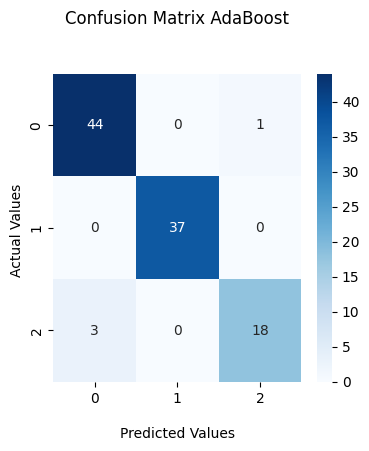

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



In [104]:
for model, model_name in zip(models_nonparametric, models_nonparametric_names):
    mod_name, mod_auc, mod_f1 = model_evaluation(model, model_name, X_test,y_test)
    new_row = pd.DataFrame({'Model': mod_name, 'F1_score': mod_f1, 'AUC': mod_auc}, index=[0])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row])

ROC_AUC_score: 0.9993873126590631
F1_score: 0.9706786228216491


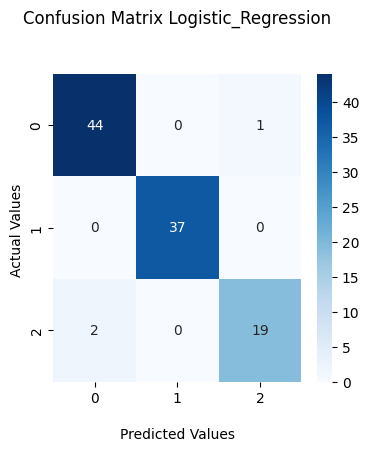

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       1.00      1.00      1.00        37
           2       0.95      0.90      0.93        21

    accuracy                           0.97       103
   macro avg       0.97      0.96      0.96       103
weighted avg       0.97      0.97      0.97       103

ROC_AUC_score: 0.999245923272693
F1_score: 0.9808031774051191


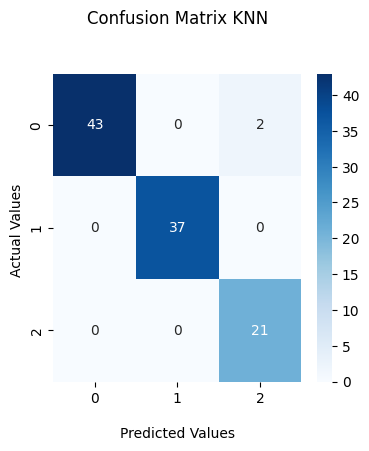

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        45
           1       1.00      1.00      1.00        37
           2       0.91      1.00      0.95        21

    accuracy                           0.98       103
   macro avg       0.97      0.99      0.98       103
weighted avg       0.98      0.98      0.98       103

ROC_AUC_score: 0.9995287020454331
F1_score: 0.9903496109655209


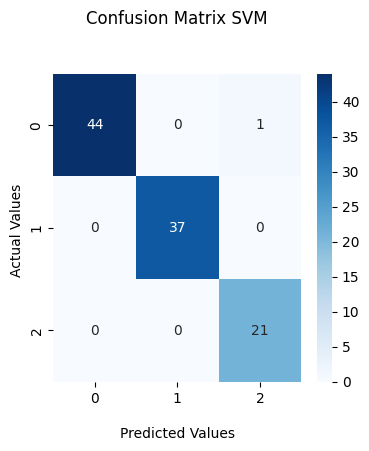

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       1.00      1.00      1.00        37
           2       0.95      1.00      0.98        21

    accuracy                           0.99       103
   macro avg       0.98      0.99      0.99       103
weighted avg       0.99      0.99      0.99       103



In [105]:
for model, model_name in zip(models_parametric, models_parametric_names):
    mod_name, mod_auc, mod_f1 = model_evaluation(model, model_name, X_test_standardized,y_test)
    new_row = pd.DataFrame({'Model': mod_name, 'F1_score': mod_f1, 'AUC': mod_auc}, index=[0])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row])


In [106]:
metrics_dataframe.sort_values(by='F1_score', ascending=False)

,Model,F1_score,AUC
0,SVM,0.990350,0.999529
0,KNN,0.980803,0.999246
0,Random_forest,0.970679,0.996748
0,Logistic_Regression,0.970679,0.999387
0,AdaBoost,0.960616,0.970874
0,Tree,0.951202,0.972877


## Voting Classifier - wybór spośród modeli parametrycznych - i nie

In [107]:
model_parametric_voting = VotingClassifier(estimators=[('Logistic', model_lr_best),
                                            ('KNN', model_knn_best),
                                            ('SVM', model_svm_best)],
                                voting='soft')
model_parametric_voting.fit(X_train_standardized, y_train)

VotingClassifier(estimators=[('Logistic',
                              LogisticRegression(C=10, l1_ratio=0.1,
                                                 multi_class='ovr',
                                                 penalty='elasticnet',
                                                 random_state=0,
                                                 solver='saga')),
                             ('KNN',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('SVM',
                              SVC(C=100, decision_function_shape='ovo',
                                  probability=True, random_state=0))],
                 voting='soft')

ROC_AUC_score: 0.9996229616363465
F1_score: 0.9805825242718447


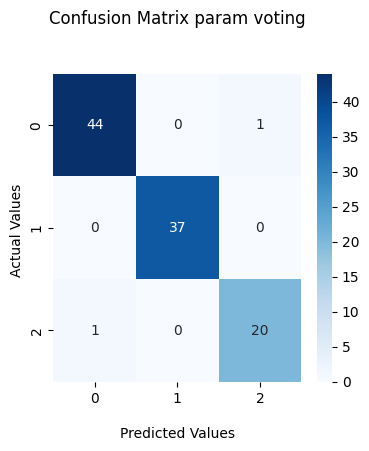

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       1.00      1.00      1.00        37
           2       0.95      0.95      0.95        21

    accuracy                           0.98       103
   macro avg       0.98      0.98      0.98       103
weighted avg       0.98      0.98      0.98       103



('param voting', 0.9996229616363465, 0.9805825242718447)

In [108]:
model_evaluation(model_parametric_voting, 'param voting', X_test_standardized,y_test)

In [109]:
model_nonparametric_voting = VotingClassifier(estimators=[('Random Forest', model_forest_best),
                                            ('AdaBoost', model_adaboost_best),
                                            ('Tree', model_tree_best)],
                                voting='soft')
model_nonparametric_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_depth=5,
                                                     min_samples_leaf=2,
                                                     random_state=0)),
                             ('AdaBoost',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.01,
                                                 n_estimators=10,
                                                 random_state=0)),
                             ('Tree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_leaf=2,
                                                     random_state=0))],
                 voting='soft')

ROC_AUC_score: 0.9964181355452917


F1_score: 0.9606162937948501


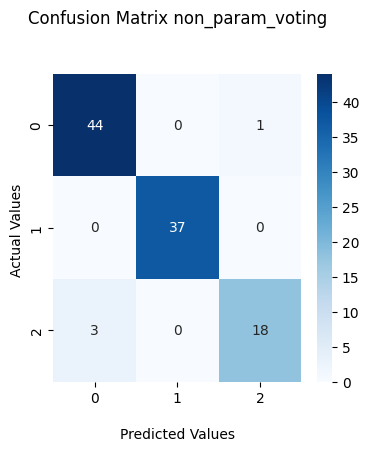

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



('non_param_voting', 0.9964181355452917, 0.9606162937948501)

In [110]:
model_evaluation(model_nonparametric_voting, 'non_param_voting', X_test,y_test)

Nie wiem dlaczego w wyniku użycia votingClassifier otrzymuję słabsze wyniki niż dla najlepszego z nauczonych uprzednio modeli.

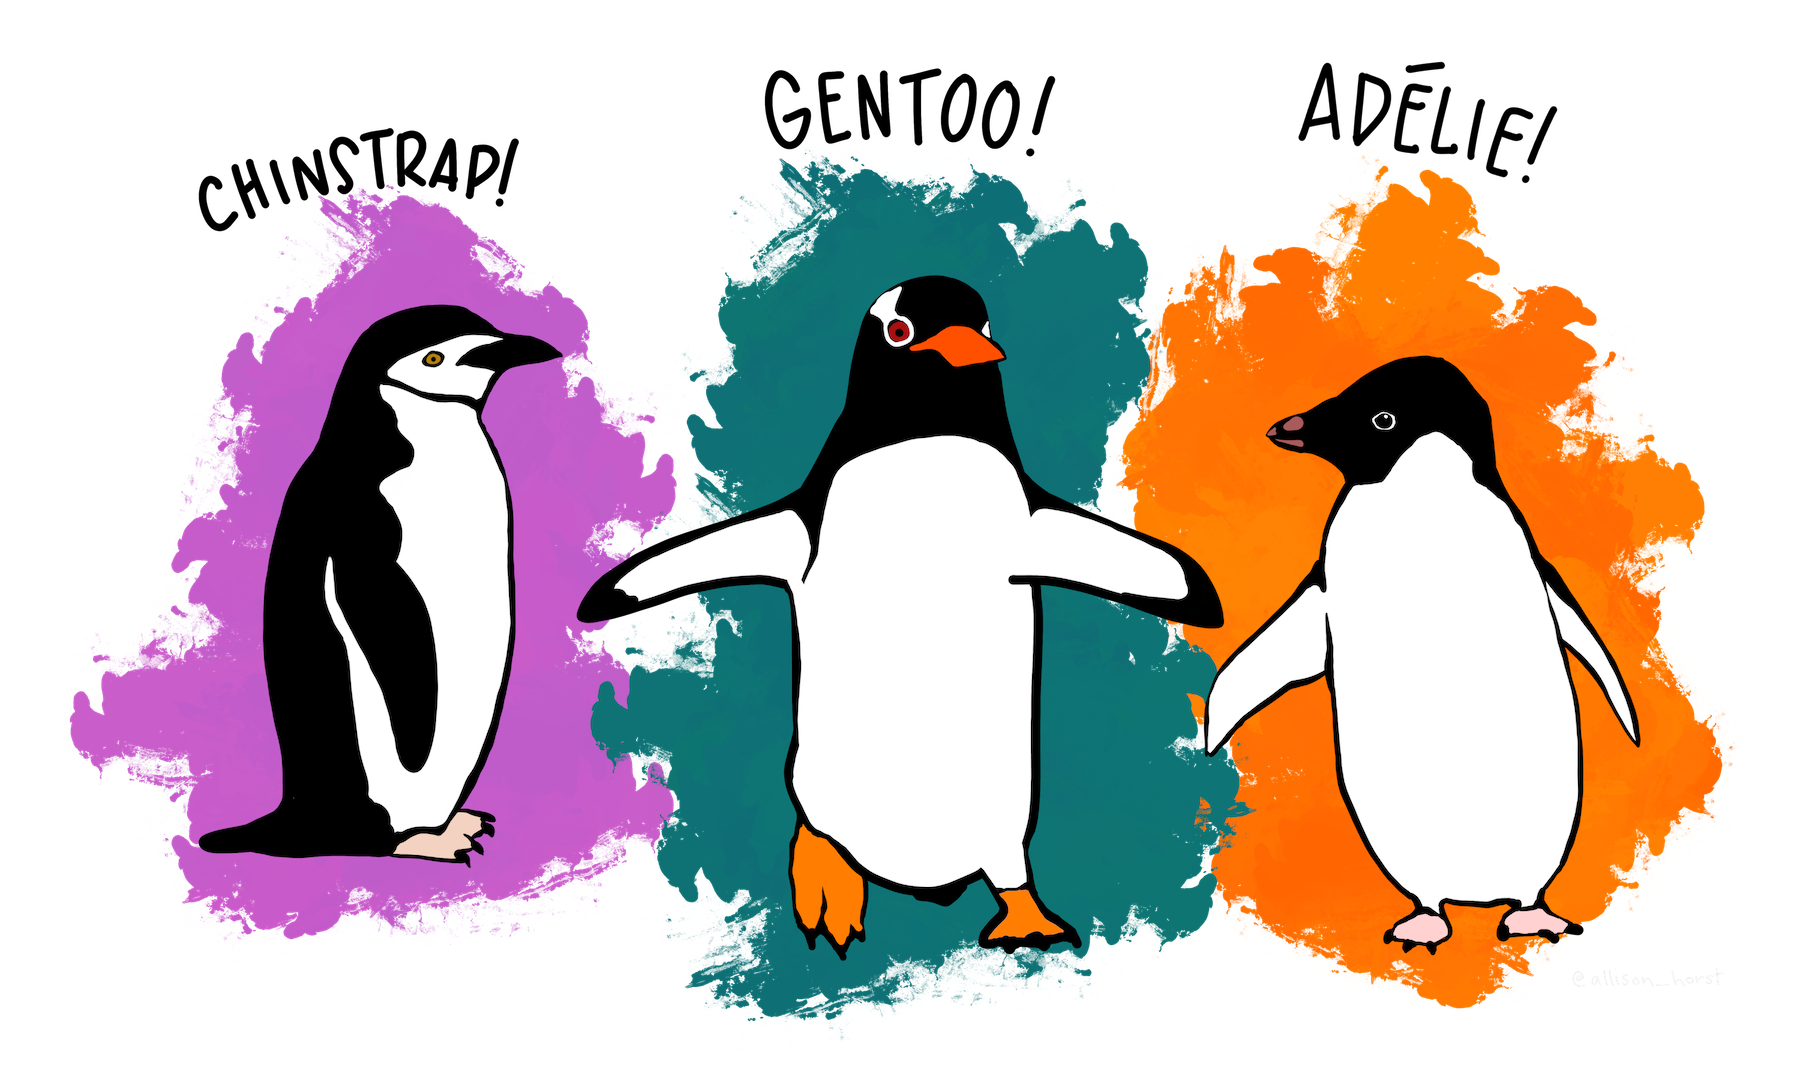